<a href="https://colab.research.google.com/github/dnth/tsai/blob/master/tutorial_nbs/11_Optuna_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Dickson Neoh - dickson.neoh@gmail.com and with incredible help from Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can take any model or dataset in TSAI and run a hyperparameter optimization job to search for optimal hyperparameter combination that yields the best result on the dataset.

## Import libraries 📚

In [1]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: latest version from github, False: stable version in pip
# if stable: 
#     !pip install tsai -U >> /dev/null
# else:      
#     !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null
# ## NOTE: REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [2]:
from tsai.all import *
p = !python  -V
print(f'python         : {p[0].split(" ")[1]}')
print(f'tsai           : {tsai.__version__}')
print(f'fastai         : {fastai.__version__}')
print(f'fastcore       : {fastcore.__version__}')
print(f'torch          : {torch.__version__}')
print(f'#cpus          : {cpus}')
iscuda = torch.cuda.is_available()
print(f'device         : {device} ({torch.cuda.get_device_name(0)})' if iscuda else f'device         : {device}')

python         : 3.8.11
tsai           : 0.2.19
fastai         : 2.5.2
fastcore       : 1.3.26
torch          : 1.9.0+cu102
#cpus          : 4
device         : cuda (GeForce GTX 980)


## Baseline 📉

Before embarking on any hyperparameter optimization tasks, it is important to get a baseline performance so that we can note the improvements after the optimization is done.
In this notebook we use the InceptionTimePlus model and and train on the NATOPS dataset, both conveniently provided in TSAI in just few lines of codes. 
Feel free to use any other models and datasets.

epoch,train_loss,valid_loss,accuracy,time
0,1.726728,1.777517,0.172222,00:00
1,1.404650,1.746338,0.227778,00:00
2,1.108030,1.705427,0.411111,00:00
3,0.919610,1.655371,0.500000,00:00
4,0.801570,1.610539,0.494444,00:00


/home/dnth/anaconda3/envs/tsai-dev/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


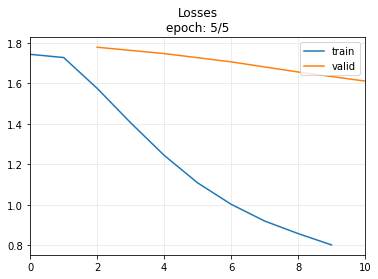

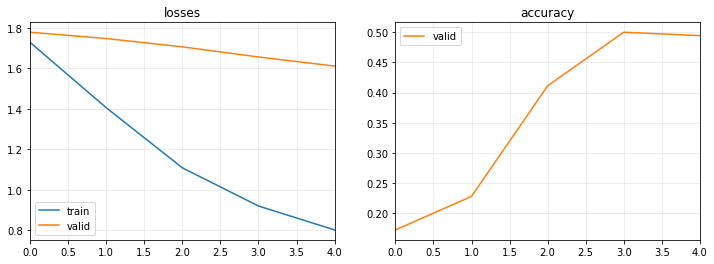

In [3]:
X, y, splits = get_UCR_data('NATOPS', split_data=False)
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=TSStandardize(by_sample=True), arch=InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(5, lr_max=1e-3)

Note the performance of the baseline model. It is about 50% accuracy on my local machine.

## Install Optuna 🕹️

[Optuna]('https://optuna.readthedocs.io/en/stable/index.html') is an automatic hyperparameter optimization software framework, particularly designed for machine learning.

In [4]:
# !pip install optuna -U >> /dev/null

## Define objective function 🎯

To define any study in Optuna, you need to create an objective function that will be optimized. The function will be different per study, but it's pretty easy to build with tsai. Below you can find an objective function that you can adapt to meet your needs.

There are two components in the objective function that you need to define:
1. Search space - the hyperparameter values that you would like to search. In this example we are searching for the combination of nf and dropout rate.
2. Objective value - the value that will be used to indicate the performance of the model. In this example we use the validation loss as the objective value.

FastAIPruningCallback is a callback that can optionally be used to prune unpromising trials (ie early stopping) in Optuna. You can choose if you want to monitor the 'valid_loss' or any metric of your choice.

In [5]:
import optuna
from optuna.integration import FastAIPruningCallback # A callback to prune unpromising trials (ie early stopping) in Optuna. Optional.

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all values in the provided list
    depth = trial.suggest_int('depth', 3, 9, step=3) # search through all values between 4 and 6
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all values between 0.0 and 1.0
    
    batch_tfms = TSStandardize(by_sample=True)
    learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=batch_tfms,
                         arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate, 'depth':depth},
                         metrics=accuracy, cbs=FastAIPruningCallback(trial))

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=1e-3)

    # Return the objective value
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

## Start the study 🧑‍🎓

In Optuna, the hyperparameter search job is known as a Study. Each Study consists of many Trials. The number of Trials indicate how many times do you want Optuna to search through the search space. After configuring the objective function above we would like to let Optuna to perform the search (study) for the combination of hyperparameters that yield the best objective value. 

📝Note: In the objective function we used the validation loss as our our objective value. Hence in the the study, we must tell Optuna minimize the objective value (This can be specified in the `direction='minimize'` as shown below). Alternatively, if you have chosen to use the accuracy metric as the objective value, you will need to tell Optuna to maximize instead. (This can be specified in the `direction='maximize'` )

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-09-20 11:30:45,779] A new study created in memory with name: no-name-45b3b78e-d24e-4925-9369-6749e2fd22d1
[I 2021-09-20 11:30:47,471] Trial 0 finished with value: 1.182837963104248 and parameters: {'num_filters': 96, 'depth': 6, 'dropout_rate': 0.0}. Best is trial 0 with value: 1.182837963104248.
[I 2021-09-20 11:30:48,141] Trial 1 finished with value: 1.17231023311615 and parameters: {'num_filters': 96, 'depth': 6, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 1.17231023311615.
[I 2021-09-20 11:30:48,391] Trial 2 finished with value: 1.560961365699768 and parameters: {'num_filters': 32, 'depth': 3, 'dropout_rate': 0.5}. Best is trial 1 with value: 1.17231023311615.
[I 2021-09-20 11:30:48,780] Trial 3 finished with value: 1.0097699165344238 and parameters: {'num_filters': 96, 'depth': 3, 'dropout_rate': 0.2}. Best is trial 3 with value: 1.0097699165344238.
[I 2021-09-20 11:30:50,802] Trial 4 finished with value: 1.5835756063461304 and parameters: {'num_filte

In [7]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.9269697666168213
  Params: 
    num_filters: 96
    depth: 3
    dropout_rate: 0.2


For reference, the default hyperparameter for the baseline `InceptionTimePlus` [model]("https://github.com/timeseriesAI/tsai/blob/main/tsai/models/InceptionTimePlus.py") is `nf=32`, `depth=6`, and `dropout_rate=0.0`

# View Plots

You will need to install plotly to view the plots

In [8]:
# !pip install plotly

In [12]:
# The following imports may be necessary ot show the plots if you are using jupyterlab
# import plotly.io as pio
# pio.renderers.default='iframe'

display(optuna.visualization.plot_optimization_history(study))

display(optuna.visualization.plot_param_importances(study))

display(optuna.visualization.plot_slice(study))

display(optuna.visualization.plot_parallel_coordinate(study))

## Retrain the model with best hyperparameters

Now that we have obtained the optimized hyperparameters from the Optuna study, we can train the InceptionTimePlus model again with the optimal hyperparameter values and note the improvement from the baseline model.

In [10]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
nf = trial.params['num_filters']
depth = trial.params['depth']
dropout_rate = trial.params['dropout_rate']

epoch,train_loss,valid_loss,accuracy,time
0,1.868642,1.774682,0.166667,00:00
1,1.287827,1.601382,0.577778,00:00
2,0.968035,1.322487,0.700000,00:00
3,0.796570,1.076718,0.700000,00:00
4,0.688694,0.940639,0.722222,00:00


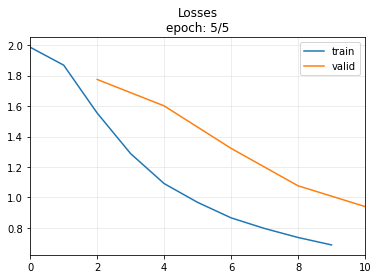

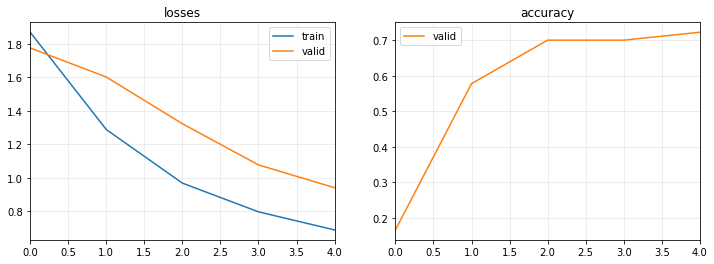

In [11]:
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], 
                     batch_tfms=TSStandardize(by_sample=True), 
                     arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate, 'depth':depth},
                     metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(5, lr_max=1e-3)


For comparison our baseline model can only scored around 50% accuracy with 5 epochs training. However, using the hyperparameters from the Optuna study results in much higher accuracy. The numbers might vary due to the randomness in training. You can seed you runs or train the model a few times to verify the results. Sometimes the study fails to find a combination that works better than the baseline. In this case you might want to increase the number of trials in the study.

Happy learning! 